## Structured Self-attentive Sentence Embedding

The code is based on [gluon-nlp tutorial](https://gluon-nlp.mxnet.io/examples/sentence_embedding/self_attentive_sentence_embedding.html).

## Import Related Packages

In [2]:
import os
import json
import zipfile
import time
import itertools

import numpy as np
import mxnet as mx
import multiprocessing as mp
import gluonnlp as nlp

from mxnet import gluon, nd, init
from mxnet.gluon import nn, rnn
from mxnet import autograd, gluon, nd
from d2l import try_gpu
import pandas as pd

# iUse sklearn's metric function to evaluate the results of the experiment
from sklearn.metrics import accuracy_score, f1_score

# fixed random number seed
np.random.seed(2333)
mx.random.seed(2333)

## Data pipeline

### Load Dataset

See [dataloader](data_loader.ipynb) for how the training samples are obtained.

In [17]:
data_folder = 'data/imdb/'
file_name = 'train.csv'
file_path = data_folder + file_name
dev = True

# load train file
if dev:
    # load only n rows
    nrows = 2000
    data = pd.read_csv(file_path, nrows=nrows)
else:
    # load as many as possible
    nrows = 100000
    data = pd.read_csv(file_path, nrows=nrows)

In [18]:
data.dropna(inplace=True)
data.shape

(2000, 4)

In [19]:
# create a list of review a label paris.
dataset = [[left, right, int(label)] for left, right, label in \
           zip(data['review_text'], data['plot_summary'], data['is_spoiler'])]
# randomly divide one percent from the training set as a verification set.
train_dataset, valid_dataset = nlp.data.train_valid_split(dataset)
len(train_dataset), len(valid_dataset)

(1900, 100)

### Data Processing

The purpose of the following code is to process the raw data so that the processed data can be used for model training and prediction. We will use the `SpacyTokenizer` to split the document into tokens, `ClipSequence` to crop the comments to the specified length, and build a vocabulary based on the word frequency of the training data. Then we attach the [Glove](https://nlp.stanford.edu/pubs/glove.pdf)[2]  pre-trained word vector to the vocabulary and convert each token into the corresponding word index in the vocabulary.
Finally get the standardized training data set and verification data set

In [20]:
# tokenizer takes as input a string and outputs a list of tokens.
tokenizer = nlp.data.SpacyTokenizer('en')

# length_clip takes as input a list and outputs a list with maximum length 300.
length_clip_review = nlp.data.ClipSequence(300)
length_clip_plot = nlp.data.ClipSequence(100)

def preprocess(x):
    # now the first element in tuple is review, second plot and third label
    left, right, label = x[0], x[1], int(x[2])
    # clip the length of review words
    left, right = length_clip_review(tokenizer(left.lower())), \
                  length_clip_plot(tokenizer(right.lower()))
    return left, right, label

def get_length(x):
    return float(len(x[0]))

def preprocess_dataset(dataset):
    start = time.time()

    with mp.Pool() as pool:
        # Each sample is processed in an asynchronous manner.
        dataset = gluon.data.ArrayDataset(pool.map(preprocess, dataset))
        lengths = gluon.data.ArrayDataset(pool.map(get_length, dataset))
    end = time.time()

    print('Done! Tokenizing Time={:.2f}s, #Sentences={}'.format(end - start, len(dataset)))
    return dataset, lengths

# Preprocess the dataset
train_dataset, train_data_lengths = preprocess_dataset(train_dataset)
valid_dataset, valid_data_lengths = preprocess_dataset(valid_dataset)

Done! Tokenizing Time=1.30s, #Sentences=1900
Done! Tokenizing Time=0.57s, #Sentences=100


In [21]:
# create vocab
train_seqs = [sample[0]+sample[1] for sample in train_dataset]
counter = nlp.data.count_tokens(list(itertools.chain.from_iterable(train_seqs)))

vocab = nlp.Vocab(counter, max_size=20000)

# load pre-trained embedding, Glove
embedding_weights = nlp.embedding.GloVe(source='glove.twitter.27B.200d')
vocab.set_embedding(embedding_weights)
print(vocab)

# NOTE: to use the same encoder, we need to ensure that two inputs are of the same length
# this is achieved by manual padding
def token_to_idx(x):
    return vocab[x[0]], vocab[x[1]], x[2]

# A token index or a list of token indices is returned according to the vocabulary.
with mp.Pool() as pool:
    train_dataset = pool.map(token_to_idx, train_dataset)
    valid_dataset = pool.map(token_to_idx, valid_dataset)

Vocab(size=20004, unk="<unk>", reserved="['<pad>', '<bos>', '<eos>']")


In [22]:
idx = vocab.embedding.token_to_idx['xmen']
idx, vocab.embedding.idx_to_vec[idx]

(11509, 
 [ 7.3501e-01  2.3659e-01  8.1485e-02  6.9116e-02 -8.2966e-02  5.1736e-01
  -2.2106e-01  1.2918e-01 -1.4550e-01  1.8944e-01  3.4552e-01 -2.7266e-01
   2.5191e-01  4.1132e-02 -2.9738e-01 -1.9861e-01  2.3085e-01  2.0603e-01
  -4.2740e-02  2.6072e-01 -6.5018e-01  5.0332e-02  1.6095e-01 -5.4888e-01
  -2.7124e-01  1.1846e-01 -5.7249e-02 -3.1976e-01 -1.1128e-01  1.8404e-01
  -2.0640e-01  4.7762e-01  3.5954e-02 -1.4585e-02 -6.9505e-02  6.1174e-01
   4.4875e-01 -5.2554e-01 -1.5218e-01  3.7220e-01  3.6481e-01 -4.6937e-01
  -9.1761e-02 -6.8574e-01 -5.4097e-01  8.5439e-01 -3.5236e-01 -2.0113e-01
  -2.0686e-01 -1.0377e+00  4.0393e-01 -7.6687e-01 -2.3442e-01  2.8207e-01
  -8.8382e-01 -5.5162e-03  6.4569e-01 -6.6990e-02  6.1193e-01  7.7833e-02
   1.2878e-01  1.1748e-01 -4.4662e-01 -1.5219e-01 -9.0765e-01  6.0395e-01
   1.4690e-01  2.9322e-01 -2.7783e-01 -5.7250e-01 -3.1507e-01  2.0820e-01
  -1.5681e-01  1.1861e+00  5.2476e-01  3.4866e-01 -4.0212e-01 -3.9851e-01
   2.9129e-01 -2.7880e-01  2.

## Bucketing and DataLoader
Since each sentence may have a different length, we need to use `Pad` to fill the sentences in a minibatch to equal lengths so that the data can be quickly tensored on the GPU. At the same time, we need to use `Stack` to stack the category tags of a batch of data. For convenience, we use `Tuple` to combine `Pad` and `Stack`.

In order to make the length of the sentence pad in each minibatch as small as possible, we should make the sentences with similar lengths in a batch as much as possible. In light of this, we consider constructing a sampler using `FixedBucketSampler`, which defines how the samples in a dataset will be iterated in a more economic way.

Finally, we use `DataLoader` to build a data loader for the training. dataset and validation dataset. The training dataset requires FixedBucketSampler, but the validation dataset doesn't require the sampler.

In [23]:
batch_size = 64
bucket_num = 10
bucket_ratio = 0.5


def get_dataloader():
    # Construct the DataLoader Pad data, stack label and lengths
    batchify_fn = nlp.data.batchify.Tuple(nlp.data.batchify.Pad(axis=0), \
                                          nlp.data.batchify.Pad(axis=0),
                                          nlp.data.batchify.Stack())

    # n this example, we use a FixedBucketSampler,
    # which assigns each data sample to a fixed bucket based on its length.
    batch_sampler = nlp.data.sampler.FixedBucketSampler(
        train_data_lengths,
        batch_size=batch_size,
        num_buckets=bucket_num,
        ratio=bucket_ratio,
        shuffle=True)
    print(batch_sampler.stats())

    # train_dataloader
    train_dataloader = gluon.data.DataLoader(
        dataset=train_dataset,
        batch_sampler=batch_sampler,
        batchify_fn=batchify_fn)
    # valid_dataloader
    valid_dataloader = gluon.data.DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        batchify_fn=batchify_fn)
    return train_dataloader, valid_dataloader

train_dataloader, valid_dataloader = get_dataloader()

FixedBucketSampler:
  sample_num=1900, batch_num=33
  key=[48, 76, 104, 132, 160, 188, 216, 244, 272, 300]
  cnt=[14, 53, 76, 123, 257, 244, 173, 107, 111, 742]
  batch_size=[200, 126, 92, 72, 64, 64, 64, 64, 64, 64]


In [24]:
# experiement one the two dataloaders
# for left, right, label in train_dataloader:
    # print(left.shape, right.shape, label.shape)

In [25]:
class WeightedSoftmaxCE(nn.HybridBlock):
    def __init__(self, sparse_label=True, from_logits=False,  **kwargs):
        super(WeightedSoftmaxCE, self).__init__(**kwargs)
        with self.name_scope():
            self.sparse_label = sparse_label
            self.from_logits = from_logits

    def hybrid_forward(self, F, pred, label, class_weight, depth=None):
        if self.sparse_label:
            label = F.reshape(label, shape=(-1, ))
            label = F.one_hot(label, depth)
        if not self.from_logits:
            pred = F.log_softmax(pred, -1)

        weight_label = F.broadcast_mul(label, class_weight)
        loss = -F.sum(pred * weight_label, axis=-1)

        # return F.mean(loss, axis=0, exclude=True)
        return loss

In [26]:
class AlignAttention(nn.Block):
    def __init__(self, **kwargs):
        super(AlignAttention, self).__init__(**kwargs)
    
    def forward(self, inp_left, inp_right):
        # input dimension is of (batch_size, seq_len, embed_size)
        # att dimension is of (batch_size, seq_len_left, seq_len_right)
        att = nd.batch_dot(inp_left, nd.transpose(inp_right, axes = (0, 2, 1)))
        # inp_left_dot dimention is of (batch_size, seq_left, embed_size)
        inp_left_dot = nd.batch_dot(nd.softmax(att, axis=-1), inp_right)
        # inp_right_dot dimension is of (batch_size, seq_right, embed_size)
        inp_right_dot = nd.batch_dot(nd.softmax(nd.transpose(att, axes=(0, 2, 1)), axis=-1), inp_left)
        # concat original (lstm output, dot multiplier, substraction, elementwise product)
        # therefore, the real size is (batch_size, seq_len_left/right, embed_size*4)
        aug_left = nd.concat(inp_left, inp_left_dot, inp_left-inp_left_dot, inp_left*inp_left_dot, dim=-1)
        aug_right = nd.concat(inp_right, inp_right_dot, inp_right-inp_right_dot, inp_right*inp_right_dot, dim=-1)
        return aug_left, aug_right, att

In [27]:
class EnhancedSeqInfer(nn.Block):
    def __init__(self, vocab_len, embsize, nhidden, nlayers, nfc, nclass, drop_prob, **kwargs):
        super(EnhancedSeqInfer, self).__init__(**kwargs)
        with self.name_scope():
            # dropout prob
            self.drop_prob = drop_prob
            # word embedding
            self.embedding_layer = nn.Embedding(vocab_len, embsize)
            # first lstm, from sentence embed to hidden outputs
            self.bilstm1 = rnn.LSTM(nhidden, num_layers=nlayers, dropout=drop_prob, bidirectional=True)
            # second lstm, from augmented embed to m
            self.bilstm2 = rnn.LSTM(nhidden, num_layers=1, dropout=drop_prob, bidirectional=True)
            # enhancement
            self.align_att = AlignAttention()
            # this layer is used to output the final class
            self.output_layer = nn.HybridSequential()
            self.output_layer.add(nn.Dense(nfc, activation='tanh'), nn.Dropout(rate=drop_prob), \
                                  nn.Dense(nfc, activation='tanh'), nn.Dropout(rate=drop_prob), \
                                  nn.Dense(nclass))

    def forward(self, inp_left, inp_right):
        # inp is a list containing left_text and right_text
        # their size: [batch, token_idx]
        # inp_embed_left/right size: [batch, seq_len, embed_size]
        inp_embed_left = self.embedding_layer(inp_left)
        inp_embed_right = self.embedding_layer(inp_right)
        # rnn requires the first dimension to be the time steps, output is (seq_len, batch_size, embed_size)
        h_output_left = self.bilstm1(nd.transpose(inp_embed_left, axes=(1, 0, 2)))
        h_output_right = self.bilstm1(nd.transpose(inp_embed_right, axes=(1, 0, 2)))
        m_left, m_right, att = self.align_att(nd.transpose(h_output_left, axes=(1, 0, 2)), \
                                                      nd.transpose(h_output_right, axes=(1, 0, 2)))
        # apply another layer of lstm
        # v_left/right shape is (seq_len, batch_size, embed_size)
        v_left = self.bilstm2(nd.transpose(m_left, axes=(1, 0, 2)))
        v_right = self.bilstm2(nd.transpose(m_right, axes=(1, 0, 2)))
        # restore v's shape (batch_size, seq_len, embed_size)
        v_left = nd.transpose(v_left, axes=(1, 0, 2))
        v_right = nd.transpose(v_right, axes=(1, 0, 2))
        # apply max pooling 1D and avg pooling 1D
        v_left_avg = nd.sum(v_left, axis=1) / v_left.shape[1]
        v_right_avg = nd.sum(v_right, axis=1) / v_right.shape[1]
        v_left_max = nd.max(v_left, axis=1)
        v_right_max = nd.max(v_right, axis=1)
        # concatenate these 4 matrices
        dense_input = nd.concat(v_left_avg, v_left_max, v_right_avg, v_left_max, dim=-1)
        
        output = self.output_layer(dense_input)
        return output, att

## Configure parameters and build models

The resulting `M` is a matrix, and the way to classify this matrix is `flatten`, `mean` or `prune`. Prune is a way of trimming parameters proposed in the original paper and has been implemented here.

In [28]:
vocab_len = len(vocab)
emsize = 200    # word embedding size
nhidden = 512   # lstm hidden_dim
nlayers = 3     # lstm layers

# final fc layer's number of hidden units and predicted number of classes
nfc = 1024
nclass = 2

drop_prob = 0.3

ctx = try_gpu()

model = EnhancedSeqInfer(vocab_len, emsize, nhidden, nlayers, nfc, nclass, drop_prob)

model.initialize(init=init.Xavier(), ctx=ctx)

# Attach a pre-trained glove word vector to the embedding layer
model.embedding_layer.weight.set_data(vocab.embedding.idx_to_vec)
# fixed the embedding layer
model.embedding_layer.collect_params().setattr('grad_req', 'null')

print(model)

train_curve, valid_curve = [], []

EnhancedSeqInfer(
  (embedding_layer): Embedding(20004 -> 200, float32)
  (bilstm1): LSTM(None -> 512, TNC, num_layers=3, dropout=0.3, bidirectional)
  (bilstm2): LSTM(None -> 512, TNC, dropout=0.3, bidirectional)
  (align_att): AlignAttention(
  
  )
  (output_layer): HybridSequential(
    (0): Dense(None -> 1024, Activation(tanh))
    (1): Dropout(p = 0.3, axes=())
    (2): Dense(None -> 1024, Activation(tanh))
    (3): Dropout(p = 0.3, axes=())
    (4): Dense(None -> 2, linear)
  )
)


In [29]:
def calculate_loss(x_left, x_right, y, model, loss, class_weight):
    pred = model(x_left, x_right)
    y = nd.array(y.asnumpy().astype('int32')).as_in_context(ctx)
    if loss_name == 'sce':
        l = loss(pred, y)
    elif loss_name == 'wsce':
        l = loss(pred, y, class_weight, class_weight.shape[0])
    else:
        raise NotImplemented
    return pred, l

In [ ]:
def one_epoch(data_iter, model, loss, trainer, ctx, is_train, epoch, \
              clip=None, class_weight=None, loss_name='sce'):

    loss_val = 0.
    total_pred = []
    total_true = []
    n_batch = 0

    for batch_x_left, batch_x_right, batch_y in data_iter:
        batch_x_left = batch_x_left.as_in_context(ctx)
        batch_x_right = batch_x_right.as_in_context(ctx)
        batch_y = batch_y.as_in_context(ctx)

        if is_train:
            with autograd.record():
                batch_pred, l = calculate_loss(batch_x_left, batch_x_right, \
                                               batch_y, model, loss, class_weight)

            # backward calculate
            l.backward()

            # clip gradient
            clip_params = [p.data() for p in model.collect_params().values()]
            if clip is not None:
                norm = nd.array([0.0], ctx)
                for param in clip_params:
                    if param.grad is not None:
                        norm += (param.grad ** 2).sum()
                norm = norm.sqrt().asscalar()
                if norm > clip:
                    for param in clip_params:
                        if param.grad is not None:
                            param.grad[:] *= clip / norm

            # update parmas
            trainer.step(batch_x_left.shape[0])

        else:
            batch_pred, l = calculate_loss(batch_x_left, batch_x_right, \
                                           batch_y, model, loss, class_weight)

        # keep result for metric
        batch_pred = nd.argmax(nd.softmax(batch_pred, axis=1), axis=1).asnumpy()
        batch_true = np.reshape(batch_y.asnumpy(), (-1, ))
        total_pred.extend(batch_pred.tolist())
        total_true.extend(batch_true.tolist())
        
        batch_loss = l.mean().asscalar()

        n_batch += 1
        loss_val += batch_loss

        # check the result of traing phase
        if is_train and n_batch % 400 == 0:
            print('epoch %d, batch %d, batch_train_loss %.4f, batch_train_acc %.3f' %
                  (epoch, n_batch, batch_loss, accuracy_score(batch_true, batch_pred)))

    # metric
    F1 = f1_score(np.array(total_true), np.array(total_pred), average='binary')
    acc = accuracy_score(np.array(total_true), np.array(total_pred))
    loss_val /= n_batch

    if is_train:
        print('epoch %d, learning_rate %.5f \n\t train_loss %.4f, acc_train %.3f, F1_train %.3f, ' %
              (epoch, trainer.learning_rate, loss_val, acc, F1))
        train_curve.append((acc, F1))
        # declay lr
        if epoch % 2 == 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.9)
    else:
        print('\t valid_loss %.4f, acc_valid %.3f, F1_valid %.3f, ' % (loss_val, acc, F1))
        valid_curve.append((acc, F1))

In [ ]:
def train_valid(data_iter_train, data_iter_valid, model, loss, trainer, \
                ctx, nepochs, clip=None, class_weight=None, loss_name='sce'):

    for epoch in range(1, nepochs+1):
        start = time.time()
        # train
        is_train = True
        one_epoch(data_iter_train, model, loss, trainer, ctx, is_train,
                  epoch, clip, class_weight, loss_name)

        # valid
        is_train = False
        one_epoch(data_iter_valid, model, loss, trainer, ctx, is_train,
                  epoch, clip, class_weight, loss_name)
        end = time.time()
        print('time %.2f sec' % (end-start))
        print("*"*100)

## Train
Now that we are training the model, we use WeightedSoftmaxCE to alleviate the problem of data category imbalance.

In [ ]:
class_weight = None
loss_name = 'sce'
optim = 'adam'
lr = 0.001
clip = .5
nepochs = 10

trainer = gluon.Trainer(model.collect_params(), optim, {'learning_rate': lr})

if loss_name == 'sce':
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
elif loss_name == 'wsce':
    loss = WeightedSoftmaxCE()
    # the value of class_weight is obtained by counting data in advance. It can be seen as a hyperparameter.
    class_weight = nd.array([1., 3.], ctx=ctx)
else:
    print('loss function {} is not implemented!'.format(loss_name))
    raise NotImplemented

In [ ]:
# train and valid
train_valid(train_dataloader, valid_dataloader, model, loss, \
            trainer, ctx, nepochs, clip=clip, class_weight=class_weight, loss_name=loss_name)

## Predict
Now we will randomly input a movie plot summary and its review to see if the model decide the review is a spoiler or not.

In [ ]:
model.save_parameters('model/esim-{:.4}.params'.format(str(valid_curve[-1][0])))
train_curve, valid_curve

In [30]:
model.load_parameters('model/esim-0.78.params')

In [31]:
right = 'john is a former police, his daughter, sarah was killed in a car accident, which he \
        did not think was purely accidental. with his investigation went deeper, he found \
        that sarah\'s boyfriend, jack, was the one to blame.'
left = 'I liked sarah and jack in this movie, but hate john, because he killed sarah'
left_token = vocab[tokenizer(left)]
right_token = vocab[tokenizer(right)]

In [33]:
left_input = nd.array(left_token, ctx=ctx).reshape(1,-1)
right_input = nd.array(right_token, ctx=ctx).reshape(1,-1)
pred, att = model(left_input, right_input)
pred
#model.embedding_layer_right.weight.list_data()


[[-0.11391769  0.70330596]]
<NDArray 1x2 @gpu(0)>

matplotlib.axes._subplots.AxesSubplot

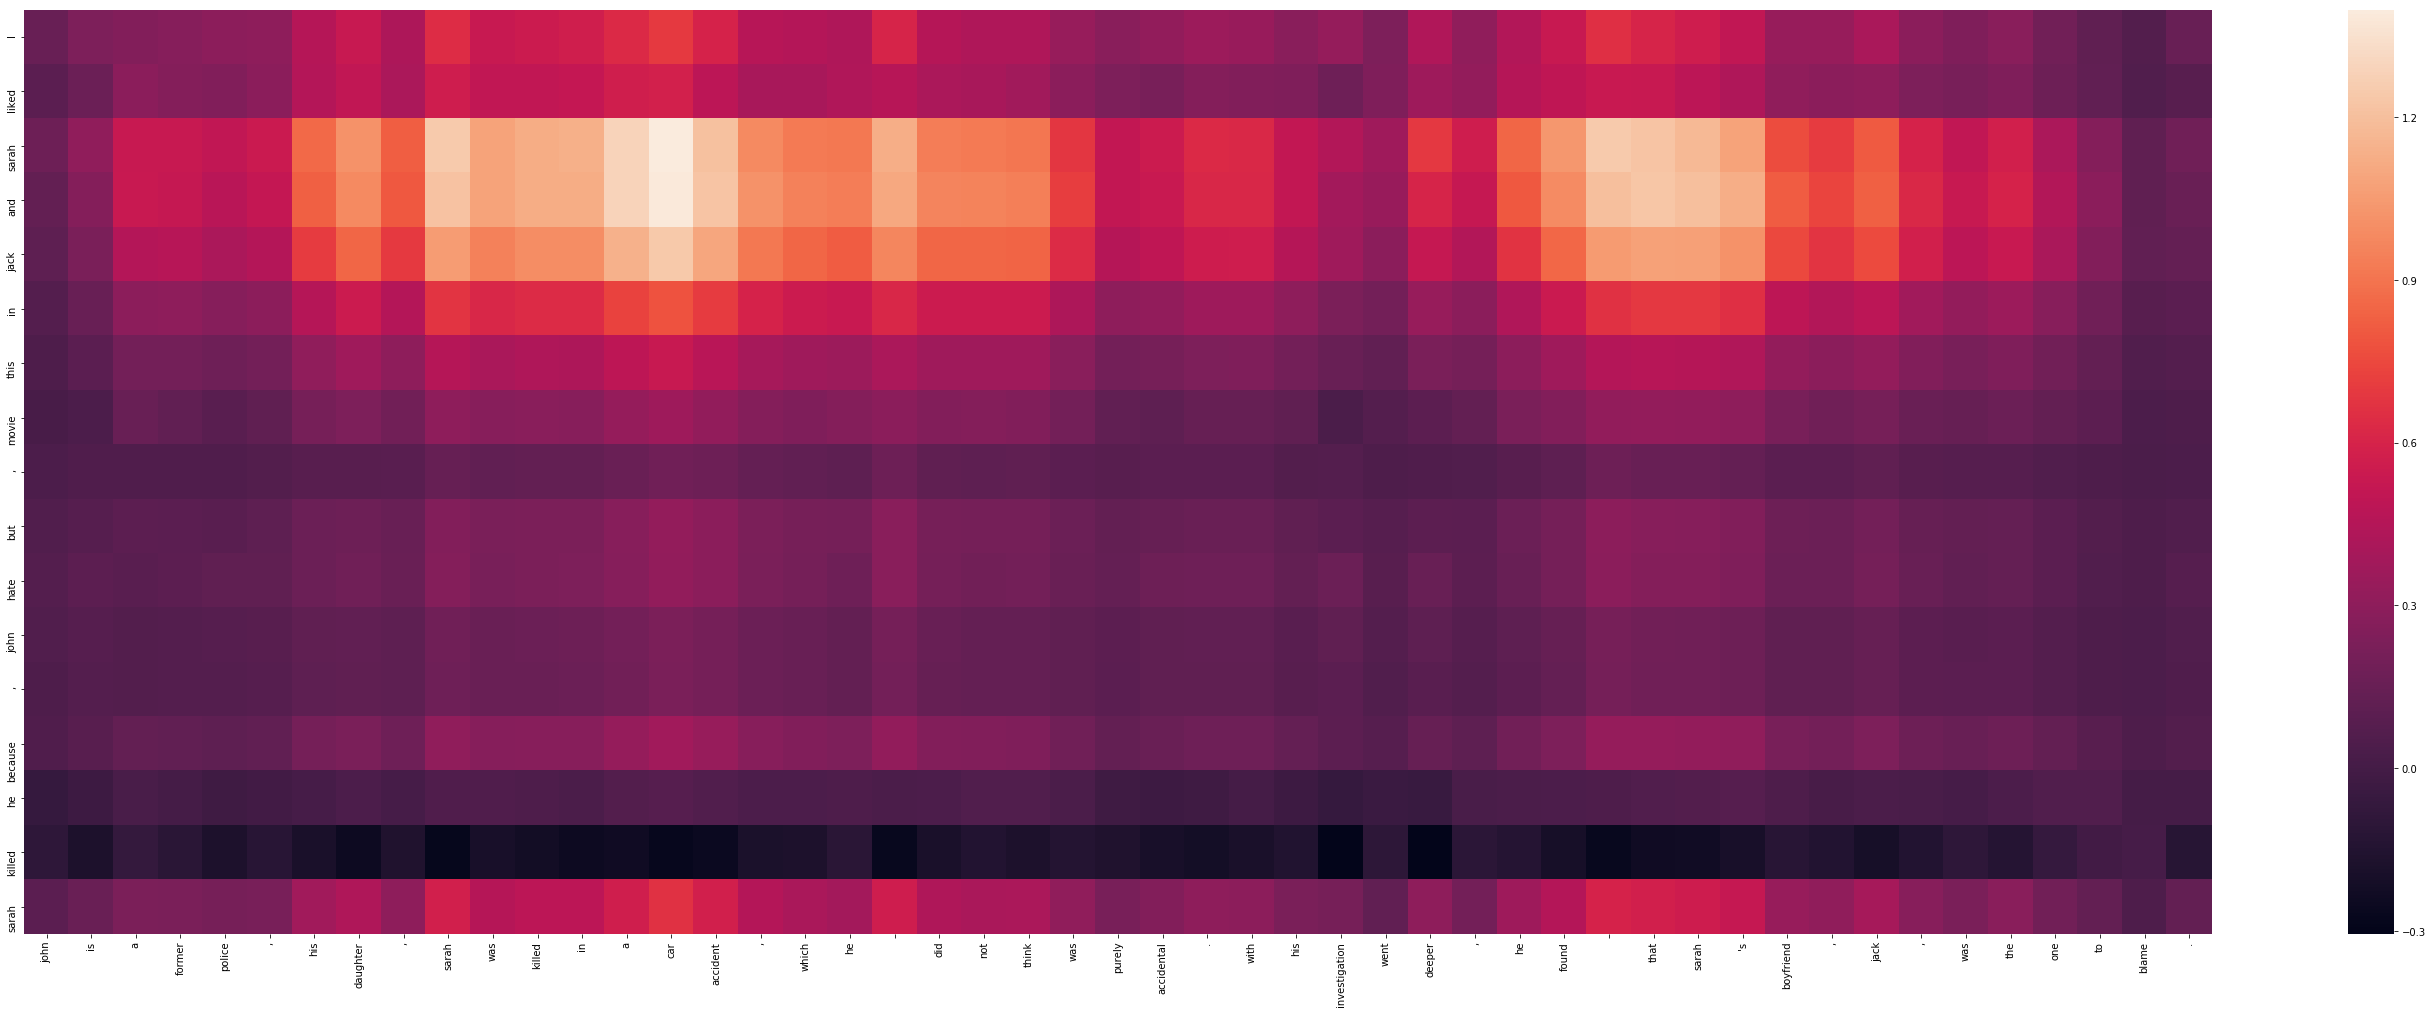

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
vis_att = np.squeeze(att.asnumpy())
plt.figure(figsize=vis_att.T.shape)
sns.heatmap(vis_att, xticklabels=tokenizer(right), yticklabels=tokenizer(left), square=False)